In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
import nltk
from nltk.corpus import stopwords
import re

In [ ]:
nltk.download('stopwords')

## Helper Functions (for the purpose of Text Loading/Processing)

In [3]:
def cleanSP(txt, stops):
    # since raw string, we split into a list of words to be iterated over
    words = txt.split()
    final = []

    # this process removes all "stop words" which helps us to improve efficiency of the task
    for word in words:
        if word not in stops:
            final.append(word)

    final = " ".join(final)

    # this is removing all punctuations for the purpose of our nlp processing
    final = final.translate(str.maketrans("","",string.punctuation))

    # removing ALL double whitespaces:
    while "  " in final:
        final = final.replace("  ", " ")
    return final

In [4]:
def loadAlbumTxt(filepath):
    rawText = None
    song_dict = {}
    
    with open(filepath, 'r') as file:
        rawText = file.read()

    # I manually transcribed the songs such that each new song will split at the key symbol '@'
    rawText = rawText.replace('\n', " ")

    # this matches any instance of a lyric such as "they-they-they" which is meant to mimic the jittering, electronic repetition of words in each song
    rawText = re.sub(r'-', r" ", rawText)
    
    song_split = rawText.split('@')

    # now I want to sort the songs into their respective title plus song name

    for song in song_split:
        titleSplit = song.split('+')
        # the following line places the song title as a key, and a further cleaned lyrics as value
        cleanedText = cleanSP(titleSplit[1], stopwords.words("english"))
        song_dict[titleSplit[0]] = cleanedText.lstrip()
    
    return song_dict

In [5]:
def loadSecondaryTxt(filepath):
    rawText = None
    
    with open(filepath, 'r') as file:
        rawText = file.read()

    # removal of newline characters
    rawText = rawText.replace('\n', " ")
    rawText = rawText.replace('-', ' ')

    # further cleaning the text to remove stopwords and punctuation
    cleanText = cleanSP(rawText, stopwords.words("english"))
    
    return cleanText

# Data Processing (Loading and Cleaning Text Corpus for NLP)

In [6]:
# First, I want to load in the each song into a "songs" dictionary
# I've manually collected most of the text documents, so minimal
# processing is needed for the songs, interviews, and reviews

brat = loadAlbumTxt('corpus/brat.txt')
brat_rmx = loadAlbumTxt('corpus/brat_remixes.txt')

# I now want to sort all of these into a "songs" dictionary (| concatenates dictionaries)
songs = brat | brat_rmx

# now with my songs sorted, I want to go ahead and load in all the other text documents. First reviews
reviews = {}
reviews['guardian'] = loadSecondaryTxt('corpus/brat_guardian_review.txt')
reviews['pitchfork_brat'] = loadSecondaryTxt('corpus/brat_pitchfork_review.txt')
reviews['pitchfork_brat_rmx'] = loadSecondaryTxt('corpus/brat_remix_pitchfork_review.txt')

# then promotional materials
promo = {}
promo['what_is_brat'] = loadSecondaryTxt('corpus/brat_tiktok_charli.txt')
promo['brat_launch_post'] = loadSecondaryTxt('corpus/brat_insta_launch.txt')

# last but not least, two hour long interviews
interviews = {}
interviews['ra'] = loadSecondaryTxt('corpus/RA_Charli_Interview.txt')
interviews['apple'] = loadSecondaryTxt('corpus/charli_apple_interview_no_speaker.txt')

# bundling them all together for later analysis. 
# using just list of string values for vectorizer processing
brat_corpus = list(songs.values()) + list(reviews.values()) + list(promo.values()) + list(interviews.values())

brat_titles = list(songs.keys()) + list(reviews.keys()) + list(promo.keys()) + list(interviews.keys())

# Beginning Analysis: TF-IDF for Brat Corpus

In [7]:
# notes to self for future reference
# min-df: ignore words across corpus that don't appear a minimunm of n integer times
# max-df: ignore words that occur within a given percentage across all documents
# ngram range = identify words that occur as 1, or as possible trigramattic usages (1-3)
vectorizer = TfidfVectorizer(lowercase=True,
                            max_features=1000,
                            max_df=.80,
                            min_df = 4,
                            ngram_range = (1,3))

vectors = vectorizer.fit_transform(brat_corpus)
feature_names = vectorizer.get_feature_names_out()

dense = vectors.todense()
denselist = dense.tolist()

all_keys = []

# this goes through, extracts words for each description, allowing us to wasier cluster the data
for text in denselist:
    x = 0
    keys = []
    for word in text:
        if word > 0:
            keys.append(feature_names[x])

        x+=1
    all_keys.append(keys)

## Determining Optimum K
- When initially experimenting with k-means clusters after my TFIDF vectorization above, I manually tested multiple clusters within the the range of 6-10. While each often generated some fairly coherent clusters, there were often times clusters who's themes (topics) were harder to discern. Thus I want to attempt to mathematically determine K, for which I select the elbow method
- Within the elbow method, I will calculate for distortion and inertia. Distortion and inertia are used to evaluate the quality of k-means cluster groupings
- Distortion is the average squard distance between each data point and the assigned cluster center, essentially measuring how well clusters actually represent the input data. Lower distortin == better clustering
- Inertia is our sum of squared distances, the actualy WCSS for the elbow method. The lower the inertia, the better
- We must locate the elbow point on a graph where we graph our output to select optimal number of clusters
- TOO FEW CLUSTERS DOES NOT CAPTURE THE STRUCTURE OF DATA, TOO MANY IS OVERFITTING (does not say anything meaningful)
- Like the calculation for LSE, it helps us to find our "clusters of best fit" essentially for the data

### Calculating Within Cluster Sum of Squared Error for Elbow Method

In [8]:
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Reducing vectors to a 2d representation via PCA (our end model will not be fitted with
# this reduced vector space, however I do this because I want to be able to 
# model an elbow model to estimate my best K for clustering

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors.T)

# checking that it is properly reduced
reduced_vectors.shape

(492, 2)

In [10]:
# First I want to calculate the Within-Cluster SSE (Sum of Squared Errors) for differing values of K
# From there, I can choose a K on the graph where WSS begins to diminish
# Within Cluster SSE is simply the distance from the predicted cluster center and its actual center

In [11]:
# Storing my distortion and inertia values in relevant lists
distortions = []
inertias = []
graph_mapping1 = {}
graph_mapping2 = {}

k_range = range(1, 40)
# Fitting K-means for multiple values of k

for k in k_range:
    k_test = KMeans(n_clusters=k, random_state=42).fit(reduced_vectors)

    # calculating my distortion (average squared distance from points to cluster centers)
    # we use euclidean distance for this calculation. Any distance metric can be used
    distortion = sum(np.min(cdist(reduced_vectors,k_test.cluster_centers_,'euclidean'),
                           axis=1)**2)/reduced_vectors.shape[0]
    distortions.append(distortion)

    # inertia thankfully is an attribute of kmeans (already calculated)
    inertias.append(k_test.inertia_)

## Graphing Outcomes of Elbow Method Calculations

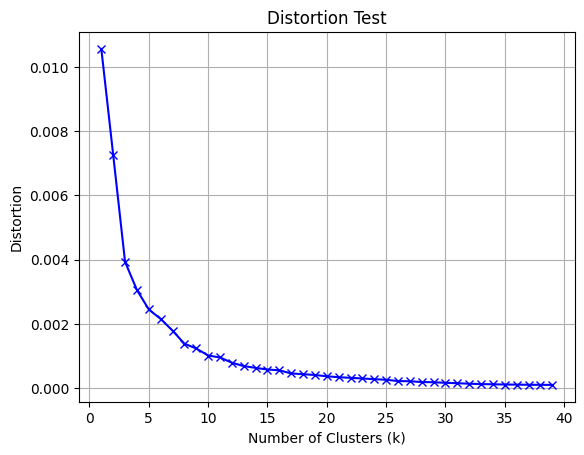

In [12]:
# Distortion Values
plt.plot(k_range, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Distortion Test')
plt.grid()
plt.show()

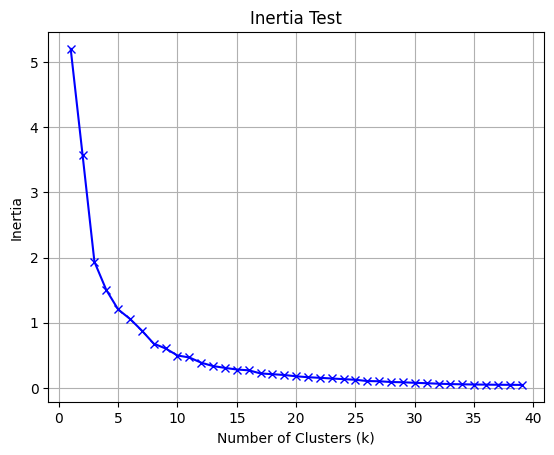

In [13]:
# Inertia Values
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia Test')
plt.grid()
plt.show()

- Based on the outcomes of my elbow analysis, I decide I want to use 5 as the number of clusters I seek in the actual data

## Performing K-means clusters on TF-IDF

In [65]:
# utilizing k-means to cluster frequent word vectors from brat corpus
# this will let us see where all our text documents fit in relation to one another
# k is selected from previous elbow method analysis 
k = 5
model = KMeans(n_clusters=k, init="k-means++", max_iter = 100, n_init=1)
model.fit(vectors)

# writing outcomes to a document to be looked at and manually analyzed (for now)
# We are sorting the centroids in this list. Centroids being the center our grous cluster around
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

with open("output_data/tfidfresults.txt", "w", encoding='utf-8') as f:
    for i in range(k):
        # listing the first ten words in eeach cluster in a text document
        f.write(f"Cluster {i}")
        f.write("\n")

        # the slicing [:10] gets me the first 10 in a given order_centroid
        for index in order_centroids[i, :10]:
            f.write(" %s" %terms[index],)
            f.write("\n")
            f.write("\n")

## Plotting my TF-IDF and K-means data
- Visualizing my data to see where my documents are plotted on a graph

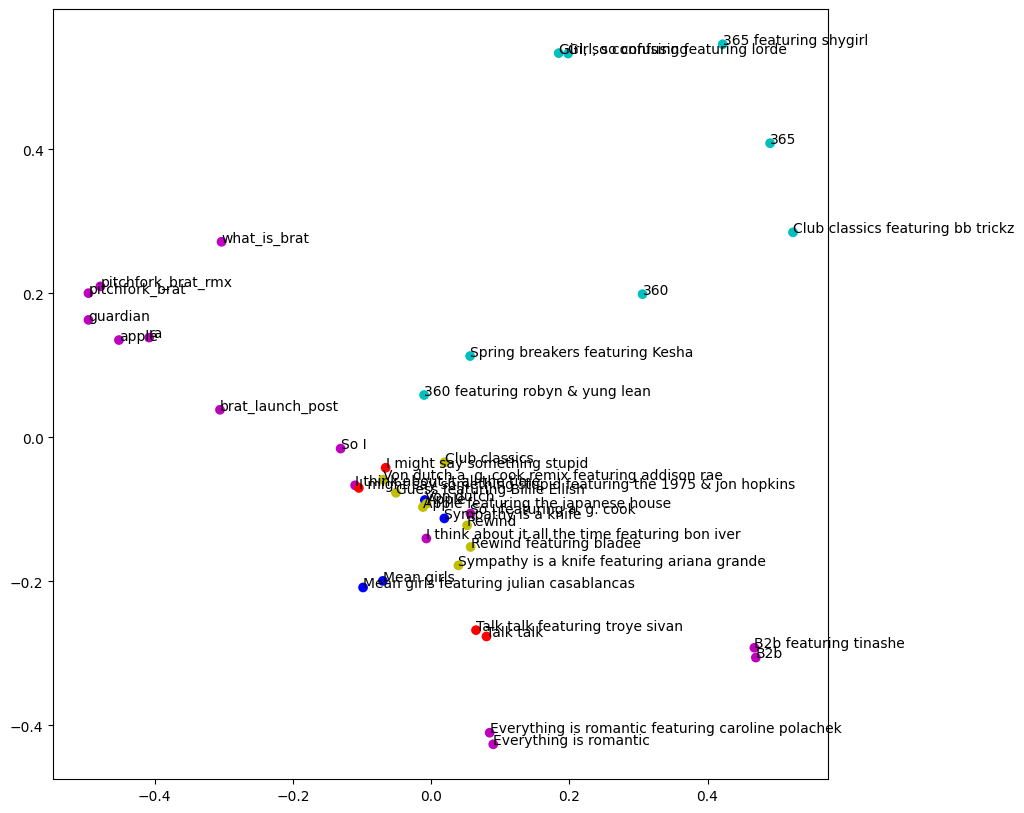

In [66]:
kmean_indices = model.fit_predict(vectors)

# new pca for plotting of vectors)
scatter_plot_points = pca.fit_transform(vectors.toarray())

colors = ["m", 'r', 'c', 'b', 'y']

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])

for i, txt in enumerate(brat_titles):
    ax.annotate(txt, (x_axis[i], y_axis[i]))

plt.savefig("output_data/test.png")
    

## Initial Conclusions from TF-IDF Exploration
- This is helpful for getting some sense of what a "center" to the brat corpus could be, including distance between topics and specific topics assigned to documents. Howeer as TF-IDF assigns only one topic, it is not unlike the problem of classical, linear categorization. That is, it fails to capture what multiple categories such as facets could. Therefore, I want to do an additional analysis, Latent Dirichlet Allocation or LDA, which will allow me to essentially have faceted topics.
- Because this is an implementation project, further explanation of the above will be relegated to a full computational grounded theory exploration of brat :)

# Latent Dirichlet Allocation Analysis
- We will be representing text as semantic vectors
- Preprocessing will be difficult here. We will use gensim as it is a standard/popularized library for Topic Modeling, particularly using LDA 

In [16]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim

## Text Processing for LDA Topic Modeling
- First we are lemmatizing the words, that is reducing them to their root, which allows for easier categorization of tokens by the LDA model
- We then run it through gensim's simple preprocess, which also lowercases and tokenizes input text. We run both to ensure the data is suitable and ready for gensim processing in LDA

In [17]:
# Reducing words down to their lemmas for easier categorization and grouping by our models
# posttag allows only for certain word to be lemmatized then added to our lemmatized corpus
def lemmatize(corpus, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    # this is a pretrained pipeline by spacy that will allow me to look at the relations between
    # given words in texts within the corpus, named entities, etc. It essentially
    # parses through the provided text efficiently while allowing me to lemmatize it as tokens
    # much easier (since it tokenizes for me)
    nlp = spacy.load("en_core_web_sm")
    corpus_out = []

    for text in corpus:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                # lemmatizing the token
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        corpus_out.append(final)
    return corpus_out

def genSimProcess(corpus):
    processed = []
    for text in corpus:
        # run the text through gensim preprocess. Append to processed list
        new = gensim.utils.simple_preprocess(text, deacc=True)
        processed.append(new)

    return processed

In [18]:
lemmatized_corpus = lemmatize(brat_corpus)
brat_data = genSimProcess(lemmatized_corpus)

In [19]:
# now we create an id to word dictionary
# This is a dictionary for words and their frequency within each text and amongst the corpus
id2word = corpora.Dictionary(brat_data)

corpus = []
for text in brat_data:
    new = id2word.doc2bow(text)
    corpus.append(new)


## Performing the LDA Modeling

In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30,
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

## Visualizing the LDA Topic Model

In [21]:
pyLDAvis.enable_notebook()

visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
visualization

/Users/carl_illustrisimo/opt/anaconda3/envs/brat/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=46407) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/carl_illustrisimo/opt/anaconda3/envs/brat/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=46407) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/carl_illustrisimo/opt/anaconda3/envs/brat/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=46407) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/carl_illustrisimo/opt/anaconda3/envs/brat/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=46407) is multi-threaded, use of fork() may lead to deadlocks in t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.238908 -0.007094       1        1  50.196286
22     0.355455  0.133406       2        1   8.249326
29    -0.339597  0.143620       3        1   4.053717
1     -0.387497 -0.055187       4        1   3.768215
9      0.053758 -0.306471       5        1   3.550192
24    -0.264736 -0.192798       6        1   3.461311
12    -0.145304 -0.314633       7        1   3.237487
4     -0.039107  0.326903       8        1   3.089675
17     0.101588  0.355804       9        1   2.785691
13     0.222471 -0.292100      10        1   2.680604
27     0.263866 -0.123842      11        1   2.539736
18    -0.141656  0.267336      12        1   2.330896
23     0.228610  0.162974      13        1   2.237066
26    -0.189699  0.167423      14        1   2.232193
6      0.092581  0.190397      15        1   1.223256
3     -0.067596  0.121563      16        1   1.214762
2     -0.215587 -0.062747      17        1   1.115128
19    -0.101153 -0.000908      18        1   0.629321
10     0.126509  0.024084      19        1   0.626431
15    -0.009218 -0.147803      20        1   0.513136
11     0.057512 -0.056716      21        1   0.207244
28     0.016328 -0.031366      22        1   0.013968
0      0.017819 -0.035393      23        1   0.005746
14     0.017672 -0.037992      24        1   0.005666
21     0.017996 -0.037598      25        1   0.005582
5      0.017748 -0.038972      26        1   0.005569
8      0.017894 -0.037076      27        1   0.005509
20     0.018139 -0.037722      28        1   0.005435
25     0.018217 -0.038352      29        1   0.005427
16     0.018077 -0.038741      30        1   0.005424, topic_info=      Term        Freq       Total Category  logprob  loglift
52    back  419.000000  419.000000  Default  30.0000  30.0000
95    girl  271.000000  271.000000  Default  29.0000  29.0000
155   talk  117.000000  117.000000  Default  28.0000  28.0000
101   know  340.000000  340.000000  Default  27.0000  27.0000
15      go  257.000000  257.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
280   come    0.000322   46.495931  Topic30  -7.6983  -2.0569
405  first    0.000321   33.022548  Topic30  -7.7037  -1.7201
67   never    0.000321   44.454487  Topic30  -7.7019  -2.0156
95    girl    0.000323  271.893534  Topic30  -7.6960  -3.8207
51    work    0.000321   62.145135  Topic30  -7.7035  -2.3523

[1791 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
740       3  0.709433      abandon
741       3  0.870530  abandonment
1591     16  0.848050     absolute
742       3  0.709379        abuse
833       2  0.692541         acid
...     ...       ...          ...
707       6  0.047665         year
707       7  0.047665         year
707      13  0.095331         year
357       1  0.429538       yellow
357       9  0.429538       yellow

[1828 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 23, 30, 2, 10, 25, 13, 5, 18, 14, 28, 19, 24, 27, 7, 4, 3, 20, 11, 16, 12, 29, 1, 15, 22, 6, 9, 21, 26, 17])

- As is perhaps visible from our initial exploration (and the cocophony of errors), many of the words do not lend to very human legible topic/theme identification. Additionally, some generated topic clusters simply overlap or are only 1 word clusters. We want to create a custom stopword removal list to identify themes more closely from these documents

## Further Textprocessing: Creating Bigrams and Trigrams and Removal of Noise
- Bigrams are
- Trigrams are
- Noise removal in this context means removing words that occur at too high a frequency as defined by a prepackaged TF-IDF model available to us from GenSim. In doing this, we hope to create topics which more closely align/are easier identified as themes

In [22]:
from gensim.models import TfidfModel

In [23]:
def makeBigrams(texts, bigram):
    # returning a set/tuple of bigram
    return [bigram[text] for text in texts]

def makeTrigrams(texts, bigram, trigram):
    # returning a set/tuple of trigram
    return [trigram[bigram[text]] for text in texts]

def tfIdfRemoval(id2word, texts, corpus, tfidf, random_sample=False):
    # the following code checks for given occurrences of words at the frequency defined by low_value
    # and them drops them from the corpus. I run the risk of omitting what is likely important
    # words, thus I want to manually adjust to keep for key words such as "brat" itself
    low_value = 0.02
    dropped_words = []
    words_missing_in_tfidf = []
    
    for i in range(0, len(corpus)):
        text = corpus[i]
        low_value_words = [] 
    
        # getting tfidf ids for words in text
        tfidf_ids = [id for id, value in tfidf[text]]
        
        text_ids = [id for id, value in text]
    
        # determine words which are low value (according to low_value frequency metric specified above)
        low_value_words = [id for id, value in tfidf[text] if value < low_value]
    
        # determines words missing in our tfidf
        words_missing_in_tfidf = [id for id in text_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing
    
        
        # creates a temp list of words which are low value and missing in our tfidf analysis, so we know what has been dropped by appending to words list above
        # I have this only happen if randomSample == False because when random sampling word-->id mappings are not perserved, leading to errors
        if (random_sample == False):
            drops = low_value_words + words_missing_in_tfidf
            for item in drops:
                dropped_words.append(id2word[item])
    
    
        new_text = [b for b in text if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    
        #reassign        
        corpus[i] = new_text

    return dropped_words

In [24]:
# Bigrams and Trigrams creation
# min count (the number of times for a pair of words to occur to be considered a bigram)
#threshold is number of phrases found
def bigramTrigram(data):
    bigram_phrases = gensim.models.Phrases(data, min_count=5, threshold=20)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[data], threshold=20)
    
    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)
    
    # This reconstitutes all our text with bigrams and trigrams identified within the lemmatized
    # and tokenized data
    data_bigrams = makeBigrams(data, bigram)
    data_bigrams_trigrams = makeTrigrams(data_bigrams, bigram, trigram)

    return data_bigrams_trigrams

In [26]:
data_bigrams_trigrams = bigramTrigram(brat_data)
# TFIDF Removals

# using our new bigram/trigram inclusive data
id2wordnew = corpora.Dictionary(data_bigrams_trigrams)
texts_new = data_bigrams_trigrams
corpus_new = [id2wordnew.doc2bow(text) for text in texts_new]

tfidf = TfidfModel(corpus_new, id2word=id2wordnew)

# Check function above for deeper description. Basically removes words with low tfIdf score
dropped_words = tfIdfRemoval(id2wordnew, texts_new, corpus_new, tfidf)

## Replotting the LDA Model After New Processing

In [27]:
lda_model_new = gensim.models.ldamodel.LdaModel(corpus=corpus_new,
                                           id2word=id2wordnew,
                                           num_topics=15,
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

visualization_new = pyLDAvis.gensim.prepare(lda_model_new, corpus_new, id2wordnew, mds="mmds", R=30)
visualization_new

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.276292 -0.240008       1        1  48.729084
2      0.118504 -0.230698       2        1   7.530313
3     -0.248581  0.217496       3        1   7.092334
10     0.221561 -0.117771       4        1   6.354467
0      0.260749  0.019455       5        1   5.963465
4      0.214454  0.167789       6        1   4.902977
7      0.059887  0.221982       7        1   3.165988
11    -0.023837 -0.225846       8        1   3.161137
9     -0.190333 -0.032765       9        1   3.126074
12    -0.080259 -0.112306      10        1   2.375518
13    -0.151079  0.080525      11        1   2.273195
5     -0.027737  0.166595      12        1   2.013843
1      0.004731  0.102304      13        1   1.641399
8      0.041160 -0.037591      14        1   0.924608
14     0.077074  0.020839      15        1   0.745597, topic_info=          Term        Freq       Total Category  logprob  loglift
386  back_back  154.000000  154.000000  Default  30.0000  30.0000
105       know  307.000000  307.000000  Default  29.0000  29.0000
15          go  192.000000  192.000000  Default  28.0000  28.0000
268       good   51.000000   51.000000  Default  27.0000  27.0000
143        get  112.000000  112.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
68       never    0.333023   38.824282  Topic15  -5.3968   0.1401
74       right    0.332151   27.920513  Topic15  -5.3995   0.4672
64         let    0.332132   15.482479  Topic15  -5.3995   1.0568
126       tell    0.331813   17.924380  Topic15  -5.4005   0.9094
181      place    0.331796   14.712647  Topic15  -5.4005   1.1068

[824 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
801       9  0.761852      abandon
802       9  0.507242  abandonment
803       9  0.761798        abuse
486      12  0.763437       action
1738      1  0.996794     actually
...     ...       ...          ...
766       1  0.574995         year
766       2  0.156817         year
766       4  0.052272         year
766       6  0.156817         year
766      11  0.052272         year

[1247 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 4, 11, 1, 5, 8, 12, 10, 13, 14, 6, 2, 9, 15])

- Things are looking much better here, and I am beginning to be able to discern certain recurrent ideas within the texts. For example, ideas of clubbing and partying as a means of going back, of a "return" in a temporal sense (topic 3). Or the interesting coupling of pop stardom, girlhood, industry, and vulnerability (topic 6).
- I want to return to this close themeing and grouping however after I've once again, like for my TFIDF model, attempted to mathematically determine an optimal number of topics
- Mainly, I want to see if I can determine a different k (topic number), as some words are recurrent in many different topics

## Findng Optimal Number of Topics (k)
- For LDA this is an ongoing field of research, with multiple metrics proposed.
- I choose to follow the model outlined in:
- - Gan J, Qi Y. Selection of the Optimal Number of Topics for LDA Topic Model-Taking Patent Policy Analysis as an Example. Entropy (Basel). 2021 Oct 3;23(10):1301. doi: 10.3390/e23101301. PMID: 34682025; PMCID: PMC8534395.
- Which combines metrics of perplexity, isolation, stability, and coincidence to optimize for (taken from the paper):
  1.  (1) good predictive ability,
  2.  (2) high isolation between topics,
  3.  (3) no duplicate topics, and
  4.  (4) repeatability.
- This frankly constitutes the most complex part of my topic modelling analysis, as I model all the math myself :). It also happens to be the most computationally heavy!

### Step 1: Generating h topic test models, with a topic number range 2 to k

In [64]:
# Self explanatory. Create h topic models, where h is 2 to k
def generateMultipleTopicModels(dictionary, corpus, texts, limit, start=2, step=1):
    models = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
 
        models.append(model)

    return models

In [29]:
models = generateMultipleTopicModels(dictionary=id2wordnew, corpus=corpus_new, texts=texts_new, start=2, limit=50)

### Step 2: With a Sampling Rate of β(0<β<1), generate multiple random samples n
- **For my beta β, I choose a sampling rate of 76%**. This is because a sample size n of 30 allows us to rely on the notion that a sample is representative of the population, and 76% should generate random n of about size 30
- This also again, sums up alot of my previous work. I first use the baseline brat_corpus list of text files which was created in the TFIDF section, then I randomly sample from it
- From the random samplke of the brat corpus, I perform all the transformations and data processing on it necessary to generate LDA models. First a lemmatization, then the gensim prebuilt pipeline, a id2word dictionary, and so on
- **Why am I repeating the aforementioned steps for each random sample?**: Multiple errors were caused by me originally trying to randomly sample from the already processed total dataset (which led to errors in disconnects from pre established mappings between words, ids, and indexes)

In [30]:
# where dataset is my corpus, and randomSamples is number of randomSamples I wish to generate
def sampleSets(dataset, randomSamples):
    sample_sets = []

    # Our beta
    percentage = 0.76
    num_samples = int(len(dataset) * percentage)

    for i in range(0, randomSamples):
        random_sample = []
        indices = np.random.choice(len(dataset),
                                   size = num_samples,
                                   replace = False)

        # this list comprehension constructs a random sample from the given indices from the random num function above
        sample_data = [dataset[i] for i in indices]

        # Starting Anew! Lemmatizing functions into new lemmatized then genSimmed data sets
        lemmatized_data = lemmatize(sample_data)
        newDataSet = genSimProcess(lemmatized_data)

        # Converting them into bigram and trigrams to create new mappings (this will prevent errors down the road that
        # were caused by me originally trying to randomly sample from the already processed total dataset (which led to errors in
        # pre established mappings between words, ids, and indexes
        properData = bigramTrigram(newDataSet)
        
      
        # Generate all respective datasets used for LDA modeling (seen above)
        id2word = corpora.Dictionary(properData)
        texts = properData
        corpus = [id2word.doc2bow(text) for text in texts]
        
        tfidf = TfidfModel(corpus, id2word=id2word)

        # perform tfIdfRemoval for corpus
        dropped_words = tfIdfRemoval(id2word, texts, corpus, tfidf, random_sample=True)

        # Append all output sample data into a list, then dictionary (sorted by random sample num)
        random_sample.append(sample_data)
        random_sample.append(id2word)
        random_sample.append(texts)
        random_sample.append(corpus)

        sample_sets.append(random_sample)
                
    return sample_sets

In [31]:
# Generate 10 random sample sets
samples = sampleSets(brat_corpus, 10)

### Step 2.1: Generate h topic test models
- Following the above, I generated 50 test models with topic number range 2-50. Thus I will generate the same number of test models, with range 2-50 for each of the random sample sets, with the random sample set randomly chosen

In [32]:
import random
random_number = random.randint(0, 9)

sample = samples[random_number]
randomModels = generateMultipleTopicModels(dictionary=sample[1], corpus=sample[3], texts=sample[2], start=2, limit=50)


In [33]:
# Confirming which randomized sample set was used
random_number 

9

In [34]:
len(randomModels)

48

In [35]:
len(models)

48

### Step 3: Calculate Stability for Models from Total Dataset and Models from Random Sample Sets for Same Number of Topics
- Given that there are 48 in the total data set sample, and that there are 48 total random sample sets. I calculate Stability is as follows:
  1. For each model with k topics, say Total_k and all Random sample i with k topics (Random_i), I will create a similarity matrix of our topics
  2. The similarity matrix will be used to find the "optimal combination"
  3. I create k x k matrices from the topics from total and random equivalents for each k.
  5. The optimal (max) Jaccard Index of these matrices will be summed and averaged. That average is my stability
  6. I will then store that calculated stability in a list for later usage
 
- Average Jaccard Score is as functions:
- - Calculate all possible average jaccard scores for all combinations of topic_i from total and topic_j from sample
  - Average jaccard score is all possible subsets of a topic compared to all possible subsets of another topic
  - Create a similarity matrix that conforms to KxK with madx average jaccard scores!

- Stability is calulated as:
   - 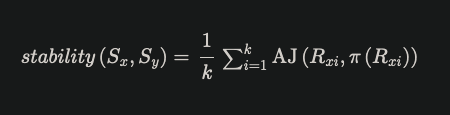
- AJ is calculated as
   - 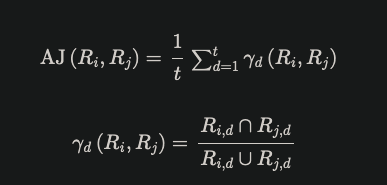

In [36]:
# function so that doing the numerator of stability formula (sum of optimal coherence combination) is easily done
def sumMaxSimilarities(matrix):
    sum = 0
    for i in range(matrix.shape[0]):
        sum += np.max(matrix[i, :])
        
    return sum

In [37]:
def jaccardIndex(matrix1, matrix2):
    # Calculate intersection and union
    intersection = np.intersect1d(matrix1, matrix2)
    union = np.union1d(matrix1, matrix2)

    intersection = len(intersection)
    union = len(union)

    # Return Jaccard Index
    return intersection/union

In [38]:
def averageJaccardIndex(matrix1, matrix2):
    summedJaccardIndexes = 0
    max_avg_jaccard = 0
    # iterate through all possible combinations of matrix subset (vocabulary depth)
    for depth in range(30): # we generated all matrices to have the top 30 words, thus 30 is max topic depth
        sub_matrix1 = matrix1[:depth + 1] # making a matrix of depth + 1 or n words in topic till depth
        sub_matrix2 = matrix2[:depth + 1] # making a matrix of depth + 1 or n words in topic till depth
  
        jaccard_index = jaccardIndex(sub_matrix1, sub_matrix2)
      
        summedJaccardIndexes += jaccard_index

        avg_jaccard = summedJaccardIndexes/ (depth+1)
        
        
    # calculate Average Jaccard Index
    return avg_jaccard

In [39]:
# test (for case of k=2, calculate 2x2 cossim matrix
k = 2

total_list = []
sample_list = []

for i in range(k):
    topic_sublist_total = []
    topic_sublist_sample = []
    for word in range(0, 30):
        total_topic = models[0].show_topic(i, topn=30)
        total_word = total_topic[word][0]
        
        sample_topic = randomModels[0].show_topic(i, topn=30)
        sample_word = sample_topic[word][0]
        
        topic_sublist_total.append(total_word)
        topic_sublist_sample.append(sample_word)

    total_list.append(topic_sublist_total)
    sample_list.append(topic_sublist_sample)


# create similarity matrix:
sim_matrix = []
for i in range(k):
    total_topic = total_list[i]
    jaccard_vector = []
    for i in range(k):
        sample_topic = sample_list[i]
        avg_jaccard = averageJaccardIndex(total_topic, sample_topic)
        jaccard_vector.append(avg_jaccard)
        
            
    sim_matrix.append(jaccard_vector)

sim_matrix = np.array(sim_matrix)
print(sim_matrix)
# optimal coherence combination is the matrix value with the highest score + the other with highest score over k values
stability = sumMaxSimilarities(sim_matrix) / k

stability

[[0.42770084 0.30683657]
 [0.14187444 0.51233634]]


0.4700185904532367

In [40]:
# In the following code I produce a list of all stabilities for all 2-50 possible k topics
# keeping track of which models we are looking at
model_count = 0

# storing stabilities
stabilities = []

# storing similarity matrices
similarity_matrices = []
# first loop (iterate through the range of all possible k (2-50))
for k in range(2, 51):
    total_list = []
    sample_list = []

    # prevents error from occurring in accessing non-indexed model
    if model_count == 48:
        break
        
    for i in range(k):
        topic_sublist_total = []
        topic_sublist_sample = []
        
        for word in range(0, 30):
            total_topic = models[model_count].show_topic(i, topn=30)
            total_word = total_topic[word][0]
            
            sample_topic = randomModels[model_count].show_topic(i, topn=30)
            sample_word = sample_topic[word][0]
            
            topic_sublist_total.append(total_word)
            topic_sublist_sample.append(sample_word)
    
        total_list.append(topic_sublist_total)
        sample_list.append(topic_sublist_sample)
    
    
    # create similarity matrix:
    sim_matrix = []
    for i in range(k):
        total_topic = total_list[i]
        jaccard_vector = []
        for i in range(k):
            sample_topic = sample_list[i]
            avg_jaccard = averageJaccardIndex(total_topic, sample_topic)
            jaccard_vector.append(avg_jaccard)
            
                
        sim_matrix.append(jaccard_vector)
    
    sim_matrix = np.array(sim_matrix)

    # optimal coherence combination is the matrix value with the highest score + the other with highest score over k values
    stability = sumMaxSimilarities(sim_matrix) / k
    
    stabilities.append(stability)
    similarity_matrices.append(sim_matrix)
    
    model_count+=1

### Step 3.1 Calculating the Coincidence of Each k-topics model pair
- Now that I have generated a list of all 48 stability pairs, we calculate coincidence
- Coincidence is taken by:
- 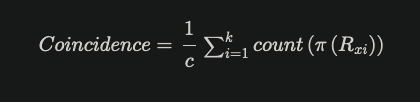
- Where the summation is of number of topics in test model and training model which coincide, that is how many time a topic from sample model occurs alongside a topic from total model.
- And c is the number of times a given topic from the column (sample model) actually occurs

In [41]:
# test (np matrices use 0 indexing). for case of 5x5 matrix (5 topics)
k = 5
sim_matrix = similarity_matrices[3]
optimal_topic_pairs = []

for i in range(k):
    row_index = i
    col_index = np.argmax(sim_matrix[row_index])
    optimal_topic_pairs.append((row_index + 1, col_index + 1))

print(optimal_topic_pairs)

c_set = {}

for pair in optimal_topic_pairs:
    # isolates the second topic, to see if occurred
    if pair[1] in list(range(1, k+1)):

        # storing these values as dict allows me to add for count of occurrences while storing unique occurences as key for c
        if pair[1] not in c_set:
            c_set[pair[1]] = 1
        else:
            c_set[pair[1]] += 1
        
# finding c by finding unique number of topic occurrences as keys
c = len(c_set.keys())

# ensuring c_set contains all other occurrences as 0

for item in list(range(1, k+1)):
    if item not in c_set:
        c_set[item] = 0

# doing the coincidence summation
coincidence = (1/c)*np.sum(list(c_set.values()))

print(c_set)
print(c)
print(coincidence)

[(1, 1), (2, 5), (3, 2), (4, 3), (5, 4)]
{1: 1, 5: 1, 2: 1, 3: 1, 4: 1}
5
1.0


In [42]:
# General Coincidences
coincidences = []
for sim_matrix in similarity_matrices:
    optimal_topic_pairs = []
    k = sim_matrix.shape[0]
    
    for i in range(k):
        row_index = i
        col_index = np.argmax(sim_matrix[row_index])
        optimal_topic_pairs.append((row_index + 1, col_index + 1))

    
    c_set = {}
    
    for pair in optimal_topic_pairs:
        # isolates the second topic, to see if occurred
        if pair[1] in list(range(1, k+1)):
    
            # storing these values as dict allows me to add for count of occurrences while storing unique occurences as key for c
            if pair[1] not in c_set:
                c_set[pair[1]] = 1
            else:
                c_set[pair[1]] += 1
            
    # finding c by finding unique number of topic occurrences as keys
    c = len(c_set.keys())
    
    # ensuring c_set contains all other occurrences as 0
    
    for item in list(range(1, k+1)):
        if item not in c_set:
            c_set[item] = 0
    
    # doing the coincidence summation
    coincidence = (1/c)*np.sum(list(c_set.values()))
    coincidences.append(coincidence)


### Step 4. Calculate the Isolation of Models Using the β x N documents 
- Here, βxN == 30
- From the paper:
- 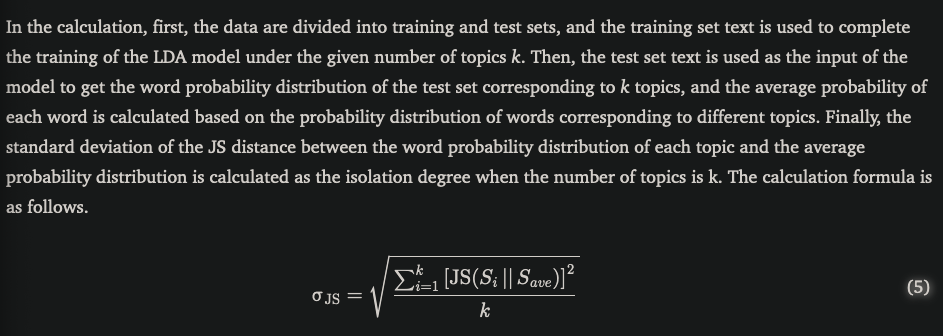
- Thus I will need to treat the sample set used (which has n of 30 from βxN) as my training set. The subtraction of the set of samples used as my training set will be utilized as my test set

### Step 4.1: Find the test set from the random training set used

In [43]:
# First, find the test set from my training set
# To do this, I perform a set substraction. Using the total set (brat_corpus) - training set (random sampke) to find test set
# remainder
training_data = samples[8]
training_set = set(training_data[0])
total_set = set(brat_corpus)
test_set = total_set - training_set

# Confirming test_set has no data loss
len(test_set)

# Result is 10, so worked. Conerting back to list
list(test_set)

# Now I want to do all my preprocessing functions for the test set

['Charli XCX’s last album designed reach many people possible Satisfying contract signed Atlantic teenager 2022’s Crash conceptual go broke pop star made name refusenik save uneasy youthful flirtations mainstream She swapped avant garde collaborators blue chip songwriters mastered slick choreo duly interpolated old dance bangers It worked becoming successful album yet Having simply decided successful pulled off artists position would surely keep it Not Charli since admitted couldn’t even listen Crash stomach rictus grin promo The sleazy grind Brat superb sixth album palate cleanser albeit one tastes like cigarettes vodka chemical afterburn Indicative unique cult status Charli returned Atlantic also intimacy shares devoted fanbase steeped 16 year evolution DIY teenage raver “your favourite reference baby” flexes confidently minimalist opener 360 You’re DOA pop right without wealth lore – ask poor Dua Lipa whose sheeny surfaces longer cut it But Charli’s remains niche subject Discord Red

In [44]:
test_data = []

# Starting Anew! Lemmatizing functions into new lemmatized then genSimmed data sets
lemmatized_test = lemmatize(test_set)
genTestData = genSimProcess(lemmatized_test)

# Converting them into bigram and trigrams to create new mappings (this will prevent errors down the road that
# were caused by me originally trying to randomly sample from the already processed total dataset (which led to errors in
# pre established mappings between words, ids, and indexes
test_data_set = bigramTrigram(genTestData)


# Generate all respective datasets used for LDA modeling (seen above)
test_id2word = corpora.Dictionary(test_data_set)
test_texts = test_data_set
test_corpus = [test_id2word.doc2bow(text) for text in test_texts]

test_tfidf = TfidfModel(test_corpus, id2word=test_id2word)

# perform tfIdfRemoval for corpus
test_dropped_words = tfIdfRemoval(test_id2word, test_texts, test_corpus, test_tfidf, random_sample=True)

#placing test_data in list container
test_data.append(test_data_set)
test_data.append(test_id2word)
test_data.append(test_texts)
test_data.append(test_corpus)


In [45]:
# Confirming that tokenized, lemmatized, genSim-ized (TLG) training data set is equal to TLG-ed test_data set
len(training_data[2])

29

In [46]:
len(test_texts)

10

### Step 4.2: Use random models with test data to get probability distributions
- Test each random model at number of topics k to get:
  1. Probability distritbution of all words in the test set of k topics
  2. The average probability of each word in the ith topic, where the ith topic corresponds to k (so if I am looking at a k of 9, I want to calculate for this the average probability of each word in the 9th topic
  3. The summation of i-k of the above through JS and KL

In [47]:
import copy
# This is so I don't muddle the model I am using to test my math :P

#### Testing for Case k = 4

In [48]:
# Test, Training and calculating for model at k = 4
current_model = copy.copy(randomModels[2])

# CALCULATING THE AVERAGE WORD PROBABILITY OF TEST SET
word_distributions = []
for doc in test_corpus:
    # in built function to perform an inference (finding probability for words and topics) for a given doc in the corpus
    gamma, _ = current_model.inference([doc])

    # This gets me the topic distribution for the document. Meaning what proportion of topics are in the test_corpus doc
    topic_dist = gamma[0] / sum(gamma[0])

    # Calculating the word probabilities for each topic for the given document (thanks GenSim documentation)
    # Note to self:
    # elog beta is the log probabilities of words given a topic, these are converted to actual probabilties by exp, then transposed (.T) into a matrix to align the topics with words, and then multipliedn(the dot product)
    # get a vector of word probabilities for the document, one which is each words probability for each topic
    word_probs = current_model.expElogbeta.T.dot(topic_dist)

    word_distributions.append(word_probs)

# This creates a matrix where row n correspondes to a nth docment, and column i corresponds to an ith word in the vocab. Each cell
# is the probability of a given word occurring within the k LDA model itself
word_distributions = np.array(word_distributions)

# Since each column corresponds to a word in a topic, averaging along the column (axis = 0) gets us
# the probabilities of each word in the topic model
avg_word_dist = np.mean(word_distributions, axis=0)

# 2126 total words in test_set. Checking if avg_word_dist == 2126
2126 == len(avg_word_dist)

avg_word_prob = np.mean(avg_word_dist)
avg_word_prob

0.00032183528

In [49]:
# CALCULATING THE WORD PROBABILITY FOR EACH TOPIC i through K (topic distributions)
topic_word_dist = current_model.get_topics()

# word distribution for specific topic
# where i == topic i
# calculating the word distribution for ith topic then adding to correspondant list
topic_distributions = []
for i in range(len(topic_word_dist)):
    topic_word_probs = topic_word_dist[i]
    average_topic_word_dist = topic_word_probs.mean()
    topic_distributions.append(average_topic_word_dist)
    
topic_distributions

[0.0005524861, 0.00055248616, 0.00055248616, 0.00055248616]

#### Creating the Standard Deviation of a JS Divergence
- **THANK THE LORD!** Some genius at SciPy already created a function to do the Jensen Shannon Divergence, so I just need to create this function:
  - 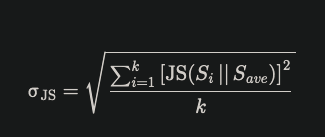

In [50]:
from scipy.spatial.distance import jensenshannon
from math import sqrt

In [51]:
# Where Sk corresponds to list of all topic distributions i through k, 
# and Sav is the average total word distribution for the test set
def stdJS(Sk, Sav):
    numerator = 0
    denominator = len(Sk) # recall number of topics is k

    # Doing the summation of jensen shannon divergence
    for Si in Sk:
        # Not symmetric, so order matters. Si must be p, Sav must be q
        numerator += jensenshannon(Si, Sk)

    return sqrt(numerator/denominator)
    

In [52]:
# Test for K = 4, moment of truth
sdJS4 = stdJS(topic_distributions, avg_word_prob)
sdJS4

0.8331642847721362

### 4.3 Calculating SD(Jensen-Shannon Divergence) for the Test Set for all i in K
- Huzzah! My testing worked :)
- Now I will turn all of the above into functions and calculate what is listed above

In [53]:
# Function returns the Si and Savg for use by the stdJS function
# Recall Sk is list of all S_i, and Savg is average probability distribution for a given K topics
def Sk_Savg(corpus, random_models):
    all_sk_savg = []
    for model in random_models:
        # I do the testing on a copy of the model to preserve its trained state
        current_model = copy.copy(model)
    
        # CALCULATING THE AVERAGE WORD PROBABILITY OF TEST SET
        word_distributions = []
        for doc in corpus:
            # in built function to perform an inference (finding probability for words and topics) for a given doc in the corpus
            gamma, _ = current_model.inference([doc])
        
            # This gets me the topic distribution for the document. Meaning what proportion of topics are in the test_corpus doc
            topic_dist = gamma[0] / sum(gamma[0])
        
            # Calculating the word probabilities for each topic for the given document (thanks GenSim documentation)
            # Note to self:
            # elog beta is the log probabilities of words given a topic, these are converted to actual probabilties by exp, then transposed (.T) into a matrix to align the topics with words, and then multipliedn(the dot product)
            # get a vector of word probabilities for the document, one which is each words probability for each topic
            word_probs = current_model.expElogbeta.T.dot(topic_dist)
        
            word_distributions.append(word_probs)
        
        # This creates a matrix where row n correspondes to a nth docment, and column i corresponds to an ith word in the vocab. Each cell
        # is the probability of a given word occurring within the k LDA model itself
        word_distributions = np.array(word_distributions)
        
        # Since each column corresponds to a word in a topic, averaging along the column (axis = 0) gets us
        # the probabilities of each word in the topic model
        avg_word_dist = np.mean(word_distributions, axis=0)
        
        avg_word_prob = np.mean(avg_word_dist)

        # CALCULATING THE WORD PROBABILITY FOR EACH TOPIC i through K (topic distributions)
        topic_word_dist = current_model.get_topics()
        
        # word distribution for specific topic
        # where i == topic i
        # calculating the word distribution for ith topic then adding to correspondant list
        topic_distributions = []
        for i in range(len(topic_word_dist)):
            topic_word_probs = topic_word_dist[i]
            average_topic_word_dist = topic_word_probs.mean()
            topic_distributions.append(average_topic_word_dist)

        temp_sk_savg = (topic_distributions, avg_word_prob)

        
        all_sk_savg.append(temp_sk_savg)

    return all_sk_savg

In [54]:
standard_JS_all = []

# Create list of all S_k, S_avg
all_sk_savg = Sk_Savg(test_corpus, randomModels)

# Input into Standard_JS function
for tuple in all_sk_savg:
    standard_JS = stdJS(tuple[0], tuple[1])
    
    # Append to ALL list
    standard_JS_all.append(standard_JS)


# Check functioned properly 
len(standard_JS_all)

48

### Step 5. Calculating Perplexity 
- Here we once again need to use the test set, although this time we will train a model on the test set for i-k. Then we will calculate the perplexity of each model
- This is because our test set == 1-(βxN)
- Thankfully, perplexity is an in-built function T_T

In [55]:
# Generating K test models
testSetModels = generateMultipleTopicModels(dictionary=test_id2word, corpus=test_corpus, texts=test_texts, start=2, limit=50)

In [56]:
def calculatePerplexities(models, corpus):
    perplexities = []

    for model in models:
        perplexity = model.log_perplexity(corpus)
        perplexities.append(perplexity)

    return perplexities

In [57]:
perplexities = calculatePerplexities(testSetModels, test_corpus)

### Step 6 + 7: Calculating Average Topic Number Superiority Scores
- Wow, what a journey. I am a better man after this, Or lesser. I can't tell. Though I actually really enjoyed reading through that paper and turning the math into code. I feel accomplished >:^)
- In any case, here I am using all lists generated: perplexities, stabilities, isolations (standardJS), and coincidences

In [58]:
def averageTopicNumberSuperiorityScores(perplexities, stabilities, isolations, coincidences):
    topic_scores = []
    
    for i in range(len(perplexities)):    
        topic_score = (perplexities[i] * coincidences[i]) / (isolations[i] * stabilities[i])
        topic_scores.append(topic_score)

    return topic_scores

In [59]:
topic_scores = averageTopicNumberSuperiorityScores(perplexities, stabilities, standard_JS_all, coincidences)
len(topic_scores)

48

### Step 8: Finding the Optimal Topic Number:
- We select the smallest topic score as a metric for the optimal number of topics, according to the paper who's math I have been instantiating in code this entire time

In [60]:
# Who's the smallest?

# I set min = topic_score[0] as a place holder
min_score = (2, topic_scores[0])

# I enumerate so I can see which topic number is relevant
for index, score in enumerate(topic_scores):
    if score < min_score[1]:
        min_score = (index + 2, score)

min_score

(12, -30.364682116668874)

- So, i wil train my final LDA model for 3 clusters. Or num_topics/k = 3

## The Final LDA Model
- With my data properly processed (sorted into bigrams and trigrams), and an estimation at the optimal number of topics achieved (again found through a series of computations I lovingly~ coded myself, outlined above in section "Finding Optimal Number of Topics K"). I graph my final model instantiation.
- LDA is evaluated through spread. These topics all boast a good intertopic distance, high internal coherence, and provide a starting point for later categorical/attributive analysis. Thus if I were to do the rest of my computational grounded theory here, I would've used this following model as my heuristic into the topics of brat (offering a number of themes to choose from, parse through, and used to categorize brat. I likely would want to add in more brat documents to the "brat corpus" so as to get a better sense of what is brat

In [63]:
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus_new,
                                           id2word=id2wordnew,
                                           num_topics=min_score[0],
                                           random_state=42,
                                           update_every=1, 
                                           passes=42,
                                           chunksize=100,
                                           alpha="auto")

visualization_final = pyLDAvis.gensim.prepare(lda_model_final, corpus_new, id2wordnew, mds="mmds", R=30)
visualization_final

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.271798  0.226035       1        1  48.610213
3      0.202810 -0.258552       2        1   7.972470
11    -0.210437 -0.081672       3        1   7.864219
8     -0.133431 -0.218115       4        1   6.528933
0      0.166652 -0.103716       5        1   6.295642
4     -0.268977  0.054318       6        1   4.802727
9      0.147990  0.038567       7        1   4.192448
10    -0.000776 -0.145471       8        1   3.574264
7      0.063523  0.150642       9        1   3.511509
5     -0.049872  0.198301      10        1   3.194708
2     -0.130570  0.128690      11        1   2.273734
1     -0.058712  0.010974      12        1   1.179132, topic_info=             Term        Freq       Total Category  logprob  loglift
386     back_back  154.000000  154.000000  Default  30.0000  30.0000
105          know  304.000000  304.000000  Default  29.0000  29.0000
15             go  192.000000  192.000000  Default  28.0000  28.0000
24           make   95.000000   95.000000  Default  27.0000  27.0000
46          think  181.000000  181.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
449          meet    0.396279   10.430616  Topic12  -5.6813   1.1700
284     sometimes    0.762105   24.294068  Topic12  -5.0273   0.9785
435  conversation    0.396278   12.206723  Topic12  -5.6813   1.0128
105          know    5.151901  304.729321  Topic12  -3.1163   0.3603
386     back_back    0.030536  154.682728  Topic12  -8.2445  -4.0898

[693 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
802       7  0.493169  abandonment
294       9  0.513514          act
486      10  0.921517       action
1738      1  0.986248     actually
1445      4  0.906246    aesthetic
...     ...       ...          ...
766       3  0.053561         year
766       4  0.160682         year
766       6  0.160682         year
766       7  0.053561         year
677       8  0.593307        yourе

[1097 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 12, 9, 1, 5, 10, 11, 8, 6, 3, 2])